In [69]:
import os
from biashandler import *
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import shapiro 
from scipy.stats import ks_2samp

In [2]:
# Loading of the Spanish CrowS-Pairs dataset, with original (1503),
# paraphrased (170), random (170) examples   
path_crows = os.getcwd()+'/data/crowspairs/es_en.csv'

In [3]:
#  Initiation of two BiasInfo objects. They use the same model ("BETO", see thesis)
#  and the difference between the object is only about the used metric for 
#  computing the PLLs. The two metrics are explained in the thesis (see Mcrows for "cp"
#  and Msal for "sz").
bias_cp = BiasInfo(path_crows, "beto", "cp")
bias_sz = BiasInfo(path_crows, "beto", "sz")

In [4]:
# Docs of sent_to_df is reported in biashandler.py

# PLLs for original examples using the two metrics. Remove # for computing.
# df_cp_or = bias_cp.sent_to_df("sent_more", "sent_less")
# df_sz_or = bias_sz.sent_to_df("sent_more", "sent_less")

In [ ]:
# PLLs for paraphrased examples using the two metrics. Remove # for computing.
#df_cp_par = bias_cp.sent_to_df("sent_more_par", "sent_less_par")
#df_sz_par = bias_sz.sent_to_df("sent_more_par", "sent_less_par")

In [ ]:
# PLLs for random examples using the two metrics. Remove # for computing.
#df_cp_ran = bias_cp.sent_to_df("sent_more_ran", "sent_less_ran")
#df_sz_ran = bias_sz.sent_to_df("sent_more_ran", "sent_less_ran")

In [ ]:
# The dfs are saved as csv files. In fact, the computing of PLLs is heavy and for this
# reason the dfs are saved as csv files.
#df_cp_or.to_csv(os.getcwd()+"/data/crowspairs/cp_beto_or.csv")
#df_sz_or.to_csv(os.getcwd()+"/data/crowspairs/sz_beto_or.csv")
#df_cp_par.to_csv(os.getcwd()+"/data/crowspairs/cp_beto_par.csv")
#df_sz_par.to_csv(os.getcwd()+"/data/crowspairs/sz_beto_par.csv")
#df_cp_ran.to_csv(os.getcwd()+"/data/crowspairs/cp_beto_ran.csv")
#df_sz_ran.to_csv(os.getcwd()+"/data/crowspairs/sz_beto_ran.csv")

In [6]:
# Loading of the csv files created above
scores_cp = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/cp_beto_or.csv")
scores_cp_par = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/cp_beto_par.csv")
scores_cp_ran = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/cp_beto_ran.csv")
scores_sal = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/sz_beto_or.csv")
scores_sal_par = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/sz_beto_par.csv")
scores_sal_ran = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/sz_beto_ran.csv")

In [7]:
# The PLL values of original examples, paraphrased examples, and random examples are combined.
cp_scores_all = scores_to_df(scores_cp, scores_cp_par, scores_cp_ran)
sz_scores_all = scores_to_df(scores_sal, scores_sal_par, scores_sal_ran)

In [ ]:
#####################################################################################################################
# Detecting bias in m
#####################################################################################################################

In [8]:
# Information about the prop. For detecting bias in m, only the original examples are considered. 
# (paraphrased and random examples are used for robustness analysis)
info_props(cp_scores_all, 0.05)

,prop,isBias,p_value
or,0.53,True,0.01624
par,0.59,True,0.01941
ran,0.52,False,0.53905


In [9]:
info_props(sz_scores_all, 0.05)

,prop,isBias,p_value
or,0.60,True,0.00000
par,0.53,False,0.44231
ran,0.56,False,0.08882


In [11]:
# test for normality, ster_cp distr.
shapiro(cp_scores_all.loc[:, "sent_more_score"])

ShapiroResult(statistic=0.9322236776351929, pvalue=1.444202788150292e-25)

In [12]:
# test for normality, noster_cp distr.
shapiro(cp_scores_all.loc[:, "sent_less_score"])

ShapiroResult(statistic=0.9313710927963257, pvalue=1.038064160592109e-25)

In [13]:
# test for normality, ster_sz distr.
shapiro(sz_scores_all.loc[:, "sent_more_score"])

ShapiroResult(statistic=0.9449213743209839, pvalue=3.000623672891544e-23)

In [14]:
# test for normality, noster_sz distr.
shapiro(sz_scores_all.loc[:, "sent_less_score"])

ShapiroResult(statistic=0.9468491673469543, pvalue=7.301970431231978e-23)

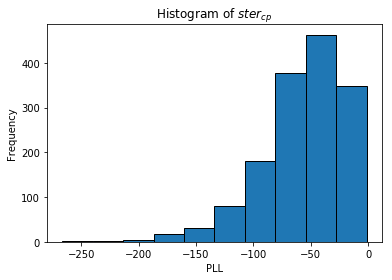

In [48]:
plt.hist(cp_scores_all.loc[:, "sent_more_score"], bins=10, edgecolor='black')
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $ster_{cp}$')
plt.show()

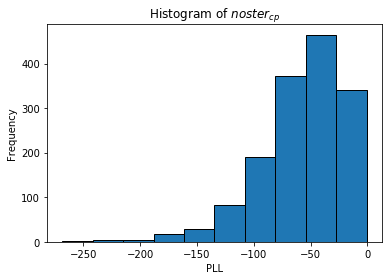

In [49]:
plt.hist(cp_scores_all.loc[:, "sent_less_score"], bins=10, edgecolor='black')
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $noster_{cp}$')
plt.show()

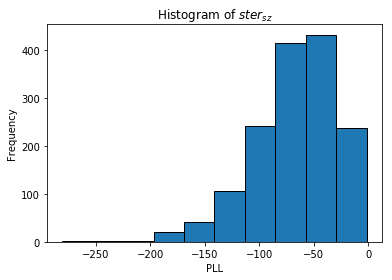

In [50]:
plt.hist(sz_scores_all.loc[:, "sent_more_score"], bins=10, edgecolor='black')
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $ster_{sz}$')
plt.show()

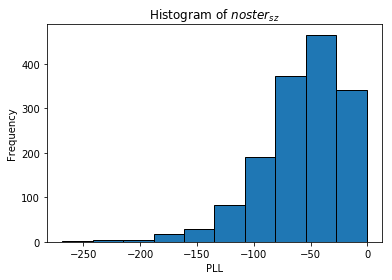

In [51]:
plt.hist(cp_scores_all.loc[:, "sent_less_score"], bins=10, edgecolor='black')
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $noster_{sz}$')
plt.show()

In [32]:
# Fitting distribution for ster_cp
sl_cp_scores = (cp_scores_all.loc[:, "sent_more_score"]).values
f_1 = Fitter(sl_cp_scores,
           distributions=['gamma',
                          'lognorm',
                          'skewnorm',
                          'genextreme',
                          "beta",
                          "burr",
                         "norm"])
f_1.fit()

Fitting 7 distributions: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.000217,1446.596375,-23651.948096,inf,0.036306,3.710846e-02
skewnorm,0.000244,1456.124634,-23473.868027,inf,0.061442,2.246446e-05
beta,0.000259,1394.150315,-23380.171247,inf,0.047449,2.223355e-03
norm,0.000386,1792.254838,-22792.570924,inf,0.071398,4.156978e-07
gamma,0.000451,1869.317673,-22553.004503,inf,0.088047,1.377017e-10


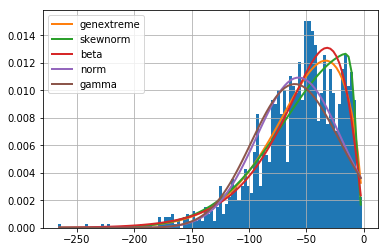

In [33]:
f_1.summary()

In [34]:
f_1.get_best()

{'genextreme': {'c': 0.6405201676548978,
  'loc': -63.1076996446696,
  'scale': 39.76725223162324}}

In [35]:
# Fitting distribution for noster_cp
sl_cp_scores = (cp_scores_all.loc[:, "sent_less_score"]).values
f_2 = Fitter(sl_cp_scores,
           distributions = ['gamma',
                          'lognorm',
                          'skewnorm',
                          'genextreme',
                          "beta",
                          "burr",
                          "norm"])
f_2.fit()

Fitting 7 distributions: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.000159,1461.815904,-24121.997900,inf,0.025367,2.833992e-01
skewnorm,0.000182,1465.642297,-23912.938529,inf,0.055741,1.684161e-04
beta,0.000196,1433.350064,-23798.359730,inf,0.038882,2.068836e-02
burr,0.000306,1439.387394,-23125.527627,inf,0.077899,2.223042e-08
norm,0.000336,1804.731408,-23002.296665,inf,0.076659,3.963410e-08


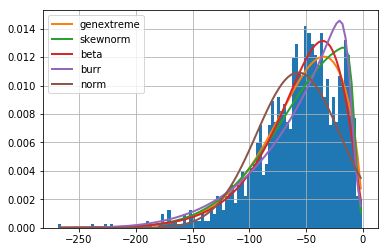

In [36]:
f_2.summary()

In [37]:
f_2.get_best()

{'genextreme': {'c': 0.6264915848145682,
  'loc': -63.59791678728531,
  'scale': 39.581971904650686}}

In [38]:
# Fitting distribution for ster_sz
sl_sz_scores = (sz_scores_all.loc[:, "sent_more_score"]).values
f_3 = Fitter(sl_sz_scores,
           distributions=['gamma',
                          'lognorm',
                          'skewnorm',
                          'genextreme',
                          "beta",
                          "burr",
                          "norm"])
f_3.fit()

Fitting 7 distributions: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.000086,1480.723784,-25046.489785,inf,0.017632,7.314338e-01
beta,0.000105,1407.155190,-24736.665794,inf,0.025941,2.594660e-01
skewnorm,0.000140,1444.422546,-24308.085192,inf,0.052766,4.459293e-04
norm,0.000210,1738.916398,-23705.675355,inf,0.066132,3.695374e-06
gamma,0.000272,1807.457831,-23312.643132,inf,0.084159,1.039660e-09


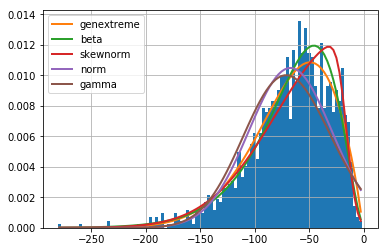

In [39]:
f_3.summary()

In [40]:
f_3.get_best()

{'genextreme': {'c': 0.5489383636498755,
  'loc': -75.8003577671272,
  'scale': 41.00468626391455}}

In [41]:
# Fitting distribution for noster_sz
sl_sz_scores = (sz_scores_all.loc[:, "sent_less_score"]).values
f_4 = Fitter(sl_sz_scores,
           distributions = ['gamma',
                          'lognorm',
                          'skewnorm',
                          'genextreme',
                          "beta",
                          "burr",
                          "norm"]) 
f_4.fit()

Fitting 7 distributions: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.000101,1551.843501,-24801.869498,inf,0.021688,4.728177e-01
beta,0.000116,1454.945616,-24584.133036,inf,0.028972,1.572629e-01
skewnorm,0.000159,1506.331670,-24121.170804,inf,0.054952,2.191854e-04
norm,0.000207,1854.520385,-23732.898045,inf,0.062300,1.630558e-05
gamma,0.000242,1917.535561,-23488.387956,inf,0.070277,6.713612e-07


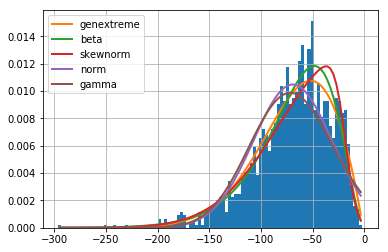

In [42]:
f_4.summary()

In [43]:
f_4.get_best()

{'genextreme': {'c': 0.5381251767072066,
  'loc': -77.95078399446045,
  'scale': 41.0082992231755}}

In [45]:
# kolmogorov smirnov test of ster_cp VS noster_cp
ks_2samp(cp_scores_all.loc[:, "sent_more_score"], cp_scores_all.loc[:, "sent_less_score"])

KstestResult(statistic=0.015302727877578177, pvalue=0.9946365642993653)

In [46]:
# kolmogorov smirnov test of ster_sz VS noster_sz
ks_2samp(sz_scores_all.loc[:, "sent_more_score"], sz_scores_all.loc[:, "sent_less_score"])

KstestResult(statistic=0.03260146373918829, pvalue=0.40156812744914877)

In [52]:
# KL Score for ster_cp and noster_cp
bias_cp.kl_div(cp_scores_all.loc[:, "sent_more_score"], cp_scores_all.loc[:, "sent_less_score"] )

50.012458611823206

In [53]:
# KL Score for ster_sz and noster_sz
bias_cp.kl_div(sz_scores_all.loc[:, "sent_more_score"], sz_scores_all.loc[:, "sent_less_score"] )

50.01110651962152

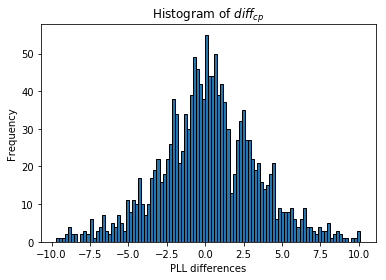

In [63]:
# Histogram of diff_cp distribution

# Computing the diff_cp distribution
diff_scores_cp = cp_scores_all.loc[:,'sent_more_score'] - cp_scores_all.loc[:,'sent_less_score']

# Quantiles for removing extreme values
q_low = diff_scores_cp.quantile(0.01)
q_hi  = diff_scores_cp.quantile(0.99)
diff_scores_cp = diff_scores_cp[(diff_scores_cp < q_hi) & (diff_scores_cp > q_low)]

plt.hist(diff_scores_cp, bins=100, edgecolor='black')
plt.xlabel('PLL differences')
plt.ylabel('Frequency')
plt.title('Histogram of $diff_{cp}$')
plt.show()

In [61]:
# Normality test for diff_cp
shapiro(diff_scores_cp)

ShapiroResult(statistic=0.994048535823822, pvalue=1.2736232747556642e-05)

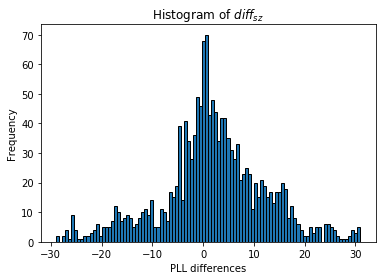

In [64]:
# Histogram of diff_sz distribution

# Computing the diff_sz distribution
diff_scores_sz = sz_scores_all.loc[:,'sent_more_score'] - sz_scores_all.loc[:,'sent_less_score']

# Quantiles for removing extreme values
q_low = diff_scores_sz.quantile(0.01)
q_hi  = diff_scores_sz.quantile(0.99)
diff_scores_sz = diff_scores_sz[(diff_scores_sz < q_hi) & (diff_scores_sz > q_low)]
plt.hist(diff_scores_sz, bins=100, edgecolor='black')

plt.xlabel('PLL differences')
plt.ylabel('Frequency')
plt.title('Histogram of $diff_{sz}$')
plt.show()

In [65]:
# Normality test for diff_sz
shapiro(diff_scores_sz)

ShapiroResult(statistic=0.9831663370132446, pvalue=4.3926954088058245e-12)

In [70]:
ztest_Score_cp, p_value_cp = ztest(diff_scores_cp,value = 0.0, alternative='two-sided')
p_value_cp

0.009027975742321677

In [71]:
ztest_Score_sz, p_value_sz = ztest(diff_scores_sz,value = 0.0, alternative='two-sided')
p_value_sz

1.1068133572560184e-12

In [ ]:
#####################################################################################################################
# Robustness of m
#####################################################################################################################

In [66]:
# Results of proportion test using the
# original and paraphrased examples
# with PLLs computed with cp
# Only the results of original
# and paraphrased examples are consider.
# For comparing the results, only 170
# are considered. 
info_props(cp_scores_all.head(170), 0.05)

,prop,isBias,p_value
or,0.58,True,0.04361
par,0.59,True,0.01941
ran,0.52,False,0.53905


In [67]:
# Results of proportion test using the
# original and paraphrased examples
# with PLLs computed with sz
# Only the results of original
# and paraphrased examples are consider.
# For comparing the results, only 170
# are considered. 
info_props(sz_scores_all.head(170), 0.05)

,prop,isBias,p_value
or,0.56,False,0.12243
par,0.53,False,0.44231
ran,0.56,False,0.08882


In [74]:
# 170 original examples, cp metric
scores_cp = scores_cp.head(170)
# Paraphrased examples
scores_cp_par = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/cp_beto_par.csv")
# Random examples
scores_cp_ran = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/cp_beto_ran.csv")

# 170 original examples, sz metric
scores_sal = scores_sal.head(170)
# Paraphrased examples
scores_sal_par = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/sz_beto_par.csv")
# Random examples
scores_sal_ran = pd.read_csv(os.getcwd()+"/data/crowspairs/csv_experiments_ch4/sz_beto_ran.csv")

In [105]:
# Proportion (l1) of examples that agree in terms of sign between original
# and paraphrased examples and between original and random examples. On l1 is
# made the proportion test.
dr = {}
examples = [scores_cp_par, scores_cp_ran]
sn = ["scores_cp_par","scores_cp_ran"]
i = 0
for ex in examples:
    s = sum(bias_cp.agree(scores_cp, ex, 'sign', -3.5, 3.5))
    #H0: prop = 0.8; H1: prop < 0.8
    pr, p_value = s/170, test_pr(s, 170, 0.8, 0.05, alt = "smaller")  
    dr["scores_cp"+"VS"+sn[i]] = [pr, p_value]
    i += 1
# Results
dr

{'scores_cpVSscores_cp_par': [0.6823529411764706, (0.00049, True)],
 'scores_cpVSscores_cp_ran': [0.5, (0.0, True)]}

In [106]:
# Proportion (l1) of examples that agree in terms of interval (as
# described in the new method proposed) between original and paraphrased examples
# and between original and random examples. On l1 is made the proportion test
dr = {}
examples = [scores_cp_par, scores_cp_ran]
sn = ["scores_cp_par","scores_cp_ran"]
i = 0
for ex in examples:
    s = sum(bias_cp.agree(scores_cp, ex, 'my_agree', -3.5, 3.5))
    #H0: prop = 0.8; H1: prop < 0.8
    pr, p_value = s/170, test_pr(s, 170, 0.8, 0.05, alt = "smaller")  
    dr["scores_cp"+"VS"+sn[i]] = [pr, p_value]
    i += 1
# Results
dr

{'scores_cpVSscores_cp_par': [0.7823529411764706, (0.28856, False)],
 'scores_cpVSscores_cp_ran': [0.5764705882352941, (0.0, True)]}

In [110]:
# two-sample Z test between the proportions scores_cpVSscores_cp_par and scores_cpVSscores_cp_ran
sm.stats.proportions_ztest([98,133], [170,170])

(-4.067131964065347, 4.759529313174206e-05)

0.5764705882352941

0.7823529411764706

(-4.067131964065347, 4.759529313174206e-05)

In [ ]:
# Robustezza

133

0.7823529411764706

(0.28856, False)

In [113]:
a = scores_cp.iloc[:,3] - scores_cp.iloc[:,4] > 0

In [114]:
b = scores_cp_par.iloc[:,3] - scores_cp_par.iloc[:,4] > 0

In [115]:
sum((scores_cp.iloc[:,3] - scores_cp.iloc[:,4]).between(-0.5, 0.5))

31

In [116]:
v = ((scores_cp.iloc[:,3] - scores_cp.iloc[:,4])-(scores_cp_par.iloc[:,3] - scores_cp_par.iloc[:,4]) ).between(-5, 5)

In [117]:
a = scores_cp.iloc[:,3] - scores_cp.iloc[:,4]
b = scores_cp_par.iloc[:,3] - scores_cp_par.iloc[:,4]
c = scores_cp_ran.iloc[:,3] - scores_cp_par.iloc[:,4]

In [118]:
sum(a.between(-0.25,0.25))/170 * 100

7.647058823529412

In [119]:
sum(b.between(-0.25,0.25))/170 * 100

11.76470588235294

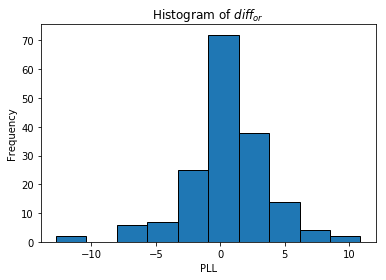

In [120]:
plt.hist(a, bins=10, edgecolor='black')
# Aggiungi etichette agli assi e un titolo
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $diff_{or}$')
# Mostra l'istogramma
plt.show()

In [ ]:
plt.hist(b, bins=10, edgecolor='black')
# Aggiungi etichette agli assi e un titolo
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $diff_{par}$')
# Mostra l'istogramma
plt.show()

In [ ]:
plt.hist(c, bins=10, edgecolor='black')
# Aggiungi etichette agli assi e un titolo
plt.xlabel('PLL')
plt.ylabel('Frequency')
plt.title('Histogram of $diff_{ran}$')
# Mostra l'istogramma
plt.show()

In [ ]:
ks_2samp(a, b)

In [ ]:
ztest_Score, p_value = ztest((a-b), value = 0.0, alternative='two-sided')

In [ ]:
ztest_Score, p_value

In [ ]:
ztest_Score, p_value = ztest((a-c), value = 0.0, alternative='two-sided')

In [ ]:
ztest_Score, p_value